This notebook implements a Vision Transformer (ViT) from scratch using PyTorch for CIFAR-10 classification.

**Paper**: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
**Authors**: Dosovitskiy et al., ICLR 2021

In [1]:
!pip install torch torchvision matplotlib numpy tqdm
!pip install timm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Configuration and Hyperparameters

Our custom configuration optimized for CIFAR-10:

In [3]:
class Config:
    # Model architecture
    img_size = 32          # CIFAR-10 image size
    patch_size = 4         # Smaller patches for small images
    num_classes = 10       # CIFAR-10 classes
    embed_dim = 320        # Embedding dimension (our choice)
    num_heads = 8          # Multi-head attention heads
    num_layers = 8         # Number of transformer blocks
    mlp_ratio = 4          # MLP hidden dimension ratio
    dropout = 0.1          # Dropout rate
    attention_dropout = 0.1

    # Training parameters
    batch_size = 128
    epochs = 50
    learning_rate = 1e-3
    weight_decay = 5e-4
    warmup_epochs = 10

    # Data augmentation
    use_mixup = True
    mixup_alpha = 0.8
    cutmix_alpha = 1.0

config = Config()

## Data Preparation with Advanced Augmentation

In [4]:
# Advanced data augmentation pipeline
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        transforms.RandomErasing(p=0.25)
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    return train_transform, test_transform

# Load CIFAR-10 dataset
train_transform, test_transform = get_transforms()

full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

# Split training set into train/validation (45k/5k split)
train_size = 45000
val_size = 5000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                       shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Training samples: 45000
Validation samples: 5000
Test samples: 10000


## Vision Transformer Implementation from Scratch

In [5]:
class PatchEmbedding(nn.Module):
    """Patch Embedding: Convert image patches to embeddings"""

    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=320):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Use convolution to create patches and embed them
        self.projection = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        # Apply convolution and reshape
        x = self.projection(x)  # (B, embed_dim, H//patch_size, W//patch_size)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

In [6]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""

    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)

        return x

In [7]:
class MLP(nn.Module):
    """Multi-Layer Perceptron with GELU activation"""

    def __init__(self, embed_dim, mlp_ratio=4, dropout=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)

        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

In [8]:
class TransformerBlock(nn.Module):
    """Transformer Encoder Block with attention and MLP"""

    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1, attention_dropout=0.1):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, attention_dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout)

        # Stochastic depth (layer dropout)
        self.drop_path = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        # Pre-norm with residual connection
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [9]:
class VisionTransformer(nn.Module):

    def __init__(self, config):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=config.img_size,
            patch_size=config.patch_size,
            embed_dim=config.embed_dim
        )

        num_patches = self.patch_embed.num_patches

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim))

        # Learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, config.embed_dim))

        self.pos_drop = nn.Dropout(config.dropout)

        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=config.embed_dim,
                num_heads=config.num_heads,
                mlp_ratio=config.mlp_ratio,
                dropout=config.dropout,
                attention_dropout=config.attention_dropout
            ) for _ in range(config.num_layers)
        ])

        # Classification head
        self.norm = nn.LayerNorm(config.embed_dim)
        self.head = nn.Linear(config.embed_dim, config.num_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # Initialize linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Classification head (use CLS token)
        x = self.norm(x[:, 0])
        x = self.head(x)

        return x

# Create model
model = VisionTransformer(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

Total parameters: 9,896,650
Trainable parameters: 9,896,650


## Training Setup and Utilities

In [10]:
def mixup_data(x, y, alpha=1.0):
    """Mixup data augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss calculation"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Cosine learning rate scheduler with warmup"""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Setup optimizer and scheduler
optimizer = optim.AdamW(model.parameters(),
                      lr=config.learning_rate,
                      weight_decay=config.weight_decay)

num_training_steps = len(train_loader) * config.epochs
num_warmup_steps = len(train_loader) * config.warmup_epochs

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing

print(f'Total training steps: {num_training_steps}')
print(f'Warmup steps: {num_warmup_steps}')

Total training steps: 17600
Warmup steps: 3520


## Training Loop

In [11]:
def train_epoch(model, loader, optimizer, scheduler, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{config.epochs}')

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        # Apply mixup with probability
        if config.use_mixup and np.random.random() > 0.5:
            data, target_a, target_b, lam = mixup_data(data, target, config.mixup_alpha)

            optimizer.zero_grad()
            output = model(data)
            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Update progress bar
        accuracy = 100. * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{accuracy:.2f}%',
            'LR': f'{scheduler.get_last_lr()[0]:.6f}'
        })

    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    return total_loss / len(loader), 100. * correct / total

In [12]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None

print('Starting training...')

for epoch in range(config.epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, epoch)

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{config.epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'  Best Val Acc: {best_val_acc:.2f}%')
    print('-' * 50)

print('Training completed!')

Starting training...


Epoch 1/50: 100%|██████████| 352/352 [01:17<00:00,  4.57it/s, Loss=1.9553, Acc=20.42%, LR=0.000100]


Epoch 1/50:
  Train Loss: 2.1302, Train Acc: 20.42%
  Val Loss: 2.0003, Val Acc: 29.12%
  Best Val Acc: 29.12%
--------------------------------------------------


Epoch 2/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=2.0784, Acc=26.05%, LR=0.000200]


Epoch 2/50:
  Train Loss: 2.0062, Train Acc: 26.05%
  Val Loss: 1.8802, Val Acc: 34.00%
  Best Val Acc: 34.00%
--------------------------------------------------


Epoch 3/50: 100%|██████████| 352/352 [01:14<00:00,  4.69it/s, Loss=1.8189, Acc=31.27%, LR=0.000300]


Epoch 3/50:
  Train Loss: 1.9108, Train Acc: 31.27%
  Val Loss: 1.7420, Val Acc: 41.80%
  Best Val Acc: 41.80%
--------------------------------------------------


Epoch 4/50: 100%|██████████| 352/352 [01:14<00:00,  4.70it/s, Loss=1.7083, Acc=33.50%, LR=0.000400]


Epoch 4/50:
  Train Loss: 1.8593, Train Acc: 33.50%
  Val Loss: 1.6730, Val Acc: 45.10%
  Best Val Acc: 45.10%
--------------------------------------------------


Epoch 5/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=2.0044, Acc=36.29%, LR=0.000500]


Epoch 5/50:
  Train Loss: 1.8110, Train Acc: 36.29%
  Val Loss: 1.7561, Val Acc: 42.02%
  Best Val Acc: 45.10%
--------------------------------------------------


Epoch 6/50: 100%|██████████| 352/352 [01:15<00:00,  4.67it/s, Loss=1.8964, Acc=36.93%, LR=0.000600]


Epoch 6/50:
  Train Loss: 1.8017, Train Acc: 36.93%
  Val Loss: 1.6503, Val Acc: 46.24%
  Best Val Acc: 46.24%
--------------------------------------------------


Epoch 7/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.6553, Acc=38.19%, LR=0.000700]


Epoch 7/50:
  Train Loss: 1.7781, Train Acc: 38.19%
  Val Loss: 1.6992, Val Acc: 44.14%
  Best Val Acc: 46.24%
--------------------------------------------------


Epoch 8/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.7786, Acc=37.46%, LR=0.000800]


Epoch 8/50:
  Train Loss: 1.7861, Train Acc: 37.46%
  Val Loss: 1.6309, Val Acc: 46.92%
  Best Val Acc: 46.92%
--------------------------------------------------


Epoch 9/50: 100%|██████████| 352/352 [01:14<00:00,  4.70it/s, Loss=1.9868, Acc=37.66%, LR=0.000900]


Epoch 9/50:
  Train Loss: 1.7746, Train Acc: 37.66%
  Val Loss: 1.6031, Val Acc: 49.04%
  Best Val Acc: 49.04%
--------------------------------------------------


Epoch 10/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.7660, Acc=36.92%, LR=0.001000]


Epoch 10/50:
  Train Loss: 1.7881, Train Acc: 36.92%
  Val Loss: 1.6738, Val Acc: 46.20%
  Best Val Acc: 49.04%
--------------------------------------------------


Epoch 11/50: 100%|██████████| 352/352 [01:14<00:00,  4.70it/s, Loss=2.0978, Acc=38.18%, LR=0.000998]


Epoch 11/50:
  Train Loss: 1.7924, Train Acc: 38.18%
  Val Loss: 1.6158, Val Acc: 48.92%
  Best Val Acc: 49.04%
--------------------------------------------------


Epoch 12/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.7094, Acc=37.15%, LR=0.000994]


Epoch 12/50:
  Train Loss: 1.7783, Train Acc: 37.15%
  Val Loss: 1.6270, Val Acc: 48.10%
  Best Val Acc: 49.04%
--------------------------------------------------


Epoch 13/50: 100%|██████████| 352/352 [01:15<00:00,  4.66it/s, Loss=1.6811, Acc=37.99%, LR=0.000986]


Epoch 13/50:
  Train Loss: 1.7835, Train Acc: 37.99%
  Val Loss: 1.6492, Val Acc: 46.98%
  Best Val Acc: 49.04%
--------------------------------------------------


Epoch 14/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.6783, Acc=39.00%, LR=0.000976]


Epoch 14/50:
  Train Loss: 1.7768, Train Acc: 39.00%
  Val Loss: 1.5953, Val Acc: 48.68%
  Best Val Acc: 49.04%
--------------------------------------------------


Epoch 15/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.8637, Acc=38.63%, LR=0.000962]


Epoch 15/50:
  Train Loss: 1.7529, Train Acc: 38.63%
  Val Loss: 1.5861, Val Acc: 49.54%
  Best Val Acc: 49.54%
--------------------------------------------------


Epoch 16/50: 100%|██████████| 352/352 [01:15<00:00,  4.67it/s, Loss=1.6507, Acc=39.15%, LR=0.000946]


Epoch 16/50:
  Train Loss: 1.7450, Train Acc: 39.15%
  Val Loss: 1.5499, Val Acc: 51.10%
  Best Val Acc: 51.10%
--------------------------------------------------


Epoch 17/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.7546, Acc=40.13%, LR=0.000926]


Epoch 17/50:
  Train Loss: 1.7242, Train Acc: 40.13%
  Val Loss: 1.5742, Val Acc: 50.20%
  Best Val Acc: 51.10%
--------------------------------------------------


Epoch 18/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.7195, Acc=39.94%, LR=0.000905]


Epoch 18/50:
  Train Loss: 1.7272, Train Acc: 39.94%
  Val Loss: 1.5336, Val Acc: 51.40%
  Best Val Acc: 51.40%
--------------------------------------------------


Epoch 19/50: 100%|██████████| 352/352 [01:15<00:00,  4.67it/s, Loss=1.4506, Acc=38.95%, LR=0.000880]


Epoch 19/50:
  Train Loss: 1.7374, Train Acc: 38.95%
  Val Loss: 1.5241, Val Acc: 53.00%
  Best Val Acc: 53.00%
--------------------------------------------------


Epoch 20/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.5778, Acc=39.80%, LR=0.000854]


Epoch 20/50:
  Train Loss: 1.7323, Train Acc: 39.80%
  Val Loss: 1.5269, Val Acc: 52.98%
  Best Val Acc: 53.00%
--------------------------------------------------


Epoch 21/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.6136, Acc=40.28%, LR=0.000825]


Epoch 21/50:
  Train Loss: 1.6988, Train Acc: 40.28%
  Val Loss: 1.5335, Val Acc: 53.28%
  Best Val Acc: 53.28%
--------------------------------------------------


Epoch 22/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.5085, Acc=40.60%, LR=0.000794]


Epoch 22/50:
  Train Loss: 1.7194, Train Acc: 40.60%
  Val Loss: 1.5040, Val Acc: 54.30%
  Best Val Acc: 54.30%
--------------------------------------------------


Epoch 23/50: 100%|██████████| 352/352 [01:15<00:00,  4.67it/s, Loss=1.4769, Acc=41.41%, LR=0.000761]


Epoch 23/50:
  Train Loss: 1.7114, Train Acc: 41.41%
  Val Loss: 1.5137, Val Acc: 54.02%
  Best Val Acc: 54.30%
--------------------------------------------------


Epoch 24/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.9804, Acc=41.97%, LR=0.000727]


Epoch 24/50:
  Train Loss: 1.6789, Train Acc: 41.97%
  Val Loss: 1.5046, Val Acc: 53.94%
  Best Val Acc: 54.30%
--------------------------------------------------


Epoch 25/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.4447, Acc=42.70%, LR=0.000691]


Epoch 25/50:
  Train Loss: 1.6744, Train Acc: 42.70%
  Val Loss: 1.5155, Val Acc: 53.42%
  Best Val Acc: 54.30%
--------------------------------------------------


Epoch 26/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.9314, Acc=41.61%, LR=0.000655]


Epoch 26/50:
  Train Loss: 1.6749, Train Acc: 41.61%
  Val Loss: 1.4742, Val Acc: 55.54%
  Best Val Acc: 55.54%
--------------------------------------------------


Epoch 27/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.9561, Acc=43.31%, LR=0.000617]


Epoch 27/50:
  Train Loss: 1.6542, Train Acc: 43.31%
  Val Loss: 1.4622, Val Acc: 55.84%
  Best Val Acc: 55.84%
--------------------------------------------------


Epoch 28/50: 100%|██████████| 352/352 [01:15<00:00,  4.67it/s, Loss=1.3090, Acc=44.89%, LR=0.000578]


Epoch 28/50:
  Train Loss: 1.6401, Train Acc: 44.89%
  Val Loss: 1.4450, Val Acc: 56.46%
  Best Val Acc: 56.46%
--------------------------------------------------


Epoch 29/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.3987, Acc=41.18%, LR=0.000539]


Epoch 29/50:
  Train Loss: 1.6520, Train Acc: 41.18%
  Val Loss: 1.4493, Val Acc: 57.02%
  Best Val Acc: 57.02%
--------------------------------------------------


Epoch 30/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.4211, Acc=45.36%, LR=0.000500]


Epoch 30/50:
  Train Loss: 1.6183, Train Acc: 45.36%
  Val Loss: 1.4484, Val Acc: 57.00%
  Best Val Acc: 57.02%
--------------------------------------------------


Epoch 31/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.5955, Acc=44.82%, LR=0.000461]


Epoch 31/50:
  Train Loss: 1.6181, Train Acc: 44.82%
  Val Loss: 1.4142, Val Acc: 58.26%
  Best Val Acc: 58.26%
--------------------------------------------------


Epoch 32/50: 100%|██████████| 352/352 [01:15<00:00,  4.65it/s, Loss=1.4426, Acc=44.59%, LR=0.000422]


Epoch 32/50:
  Train Loss: 1.6160, Train Acc: 44.59%
  Val Loss: 1.4101, Val Acc: 59.06%
  Best Val Acc: 59.06%
--------------------------------------------------


Epoch 33/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.7247, Acc=46.96%, LR=0.000383]


Epoch 33/50:
  Train Loss: 1.5773, Train Acc: 46.96%
  Val Loss: 1.4071, Val Acc: 58.48%
  Best Val Acc: 59.06%
--------------------------------------------------


Epoch 34/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.4268, Acc=46.87%, LR=0.000345]


Epoch 34/50:
  Train Loss: 1.5861, Train Acc: 46.87%
  Val Loss: 1.3660, Val Acc: 60.88%
  Best Val Acc: 60.88%
--------------------------------------------------


Epoch 35/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.7660, Acc=45.34%, LR=0.000309]


Epoch 35/50:
  Train Loss: 1.5780, Train Acc: 45.34%
  Val Loss: 1.3527, Val Acc: 61.10%
  Best Val Acc: 61.10%
--------------------------------------------------


Epoch 36/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.5290, Acc=46.67%, LR=0.000273]


Epoch 36/50:
  Train Loss: 1.5718, Train Acc: 46.67%
  Val Loss: 1.3776, Val Acc: 60.52%
  Best Val Acc: 61.10%
--------------------------------------------------


Epoch 37/50: 100%|██████████| 352/352 [01:15<00:00,  4.67it/s, Loss=1.4719, Acc=47.17%, LR=0.000239]


Epoch 37/50:
  Train Loss: 1.5695, Train Acc: 47.17%
  Val Loss: 1.3640, Val Acc: 60.76%
  Best Val Acc: 61.10%
--------------------------------------------------


Epoch 38/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.8429, Acc=45.92%, LR=0.000206]


Epoch 38/50:
  Train Loss: 1.5740, Train Acc: 45.92%
  Val Loss: 1.3404, Val Acc: 62.58%
  Best Val Acc: 62.58%
--------------------------------------------------


Epoch 39/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.3356, Acc=47.15%, LR=0.000175]


Epoch 39/50:
  Train Loss: 1.5726, Train Acc: 47.15%
  Val Loss: 1.3353, Val Acc: 61.96%
  Best Val Acc: 62.58%
--------------------------------------------------


Epoch 40/50: 100%|██████████| 352/352 [01:15<00:00,  4.66it/s, Loss=1.4422, Acc=48.40%, LR=0.000146]


Epoch 40/50:
  Train Loss: 1.5538, Train Acc: 48.40%
  Val Loss: 1.3321, Val Acc: 62.54%
  Best Val Acc: 62.58%
--------------------------------------------------


Epoch 41/50: 100%|██████████| 352/352 [01:15<00:00,  4.67it/s, Loss=1.5647, Acc=48.45%, LR=0.000120]


Epoch 41/50:
  Train Loss: 1.5360, Train Acc: 48.45%
  Val Loss: 1.3200, Val Acc: 62.30%
  Best Val Acc: 62.58%
--------------------------------------------------


Epoch 42/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.3734, Acc=46.88%, LR=0.000095]


Epoch 42/50:
  Train Loss: 1.5628, Train Acc: 46.88%
  Val Loss: 1.3122, Val Acc: 63.54%
  Best Val Acc: 63.54%
--------------------------------------------------


Epoch 43/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.3470, Acc=47.98%, LR=0.000074]


Epoch 43/50:
  Train Loss: 1.5239, Train Acc: 47.98%
  Val Loss: 1.3096, Val Acc: 63.00%
  Best Val Acc: 63.54%
--------------------------------------------------


Epoch 44/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.4215, Acc=49.32%, LR=0.000054]


Epoch 44/50:
  Train Loss: 1.5263, Train Acc: 49.32%
  Val Loss: 1.3008, Val Acc: 62.98%
  Best Val Acc: 63.54%
--------------------------------------------------


Epoch 45/50: 100%|██████████| 352/352 [01:15<00:00,  4.66it/s, Loss=1.6412, Acc=48.16%, LR=0.000038]


Epoch 45/50:
  Train Loss: 1.5469, Train Acc: 48.16%
  Val Loss: 1.3111, Val Acc: 63.80%
  Best Val Acc: 63.80%
--------------------------------------------------


Epoch 46/50: 100%|██████████| 352/352 [01:15<00:00,  4.68it/s, Loss=1.2763, Acc=50.32%, LR=0.000024]


Epoch 46/50:
  Train Loss: 1.5141, Train Acc: 50.32%
  Val Loss: 1.3047, Val Acc: 63.22%
  Best Val Acc: 63.80%
--------------------------------------------------


Epoch 47/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.2902, Acc=48.72%, LR=0.000014]


Epoch 47/50:
  Train Loss: 1.5214, Train Acc: 48.72%
  Val Loss: 1.3070, Val Acc: 62.50%
  Best Val Acc: 63.80%
--------------------------------------------------


Epoch 48/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.5603, Acc=50.30%, LR=0.000006]


Epoch 48/50:
  Train Loss: 1.4972, Train Acc: 50.30%
  Val Loss: 1.3153, Val Acc: 62.88%
  Best Val Acc: 63.80%
--------------------------------------------------


Epoch 49/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.3344, Acc=47.52%, LR=0.000002]


Epoch 49/50:
  Train Loss: 1.5413, Train Acc: 47.52%
  Val Loss: 1.3078, Val Acc: 62.92%
  Best Val Acc: 63.80%
--------------------------------------------------


Epoch 50/50: 100%|██████████| 352/352 [01:15<00:00,  4.69it/s, Loss=1.6778, Acc=50.26%, LR=0.000000]


Epoch 50/50:
  Train Loss: 1.5350, Train Acc: 50.26%
  Val Loss: 1.3055, Val Acc: 63.74%
  Best Val Acc: 63.80%
--------------------------------------------------
Training completed!


## Final Evaluation

In [15]:
# Load best model for final evaluation
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Final test evaluation
test_loss, test_acc = validate(model, test_loader, criterion)

print(f'\nFINAL RESULTS:')
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
print(f'Final Test Accuracy: {test_acc:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


FINAL RESULTS:
Best Validation Accuracy: 63.80%
Final Test Accuracy: 66.93%
Test Loss: 1.2189


## Visualization and Analysis

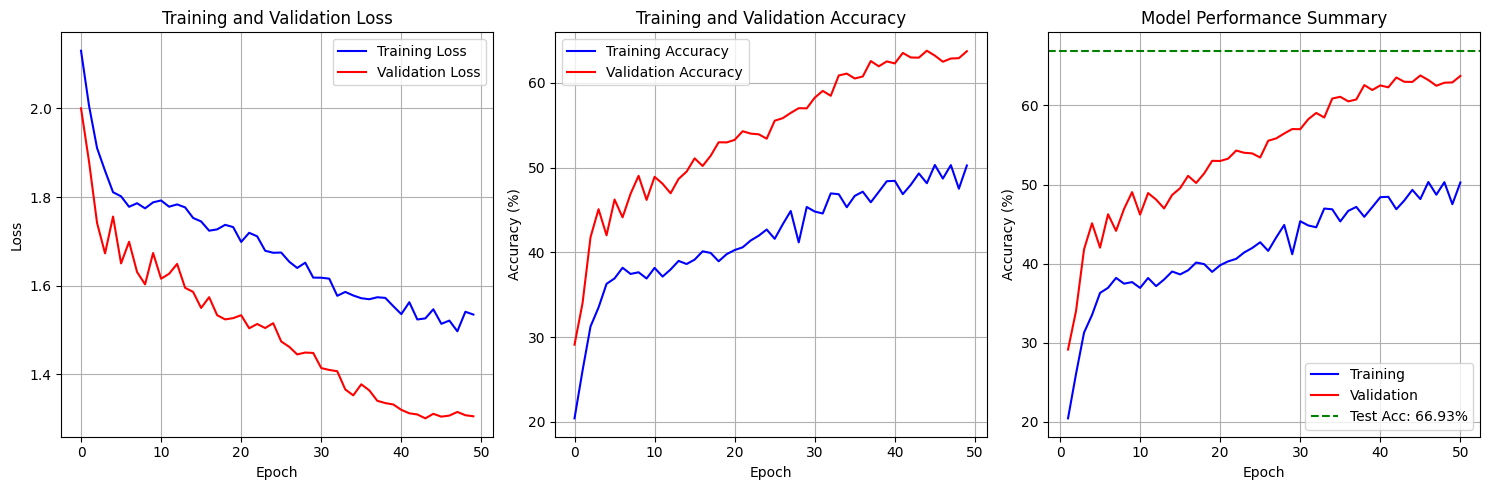

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
epochs_range = range(1, len(train_accuracies) + 1)
plt.plot(epochs_range, train_accuracies, label='Training', color='blue')
plt.plot(epochs_range, val_accuracies, label='Validation', color='red')
plt.axhline(y=test_acc, color='green', linestyle='--', label=f'Test Acc: {test_acc:.2f}%')
plt.title('Model Performance Summary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

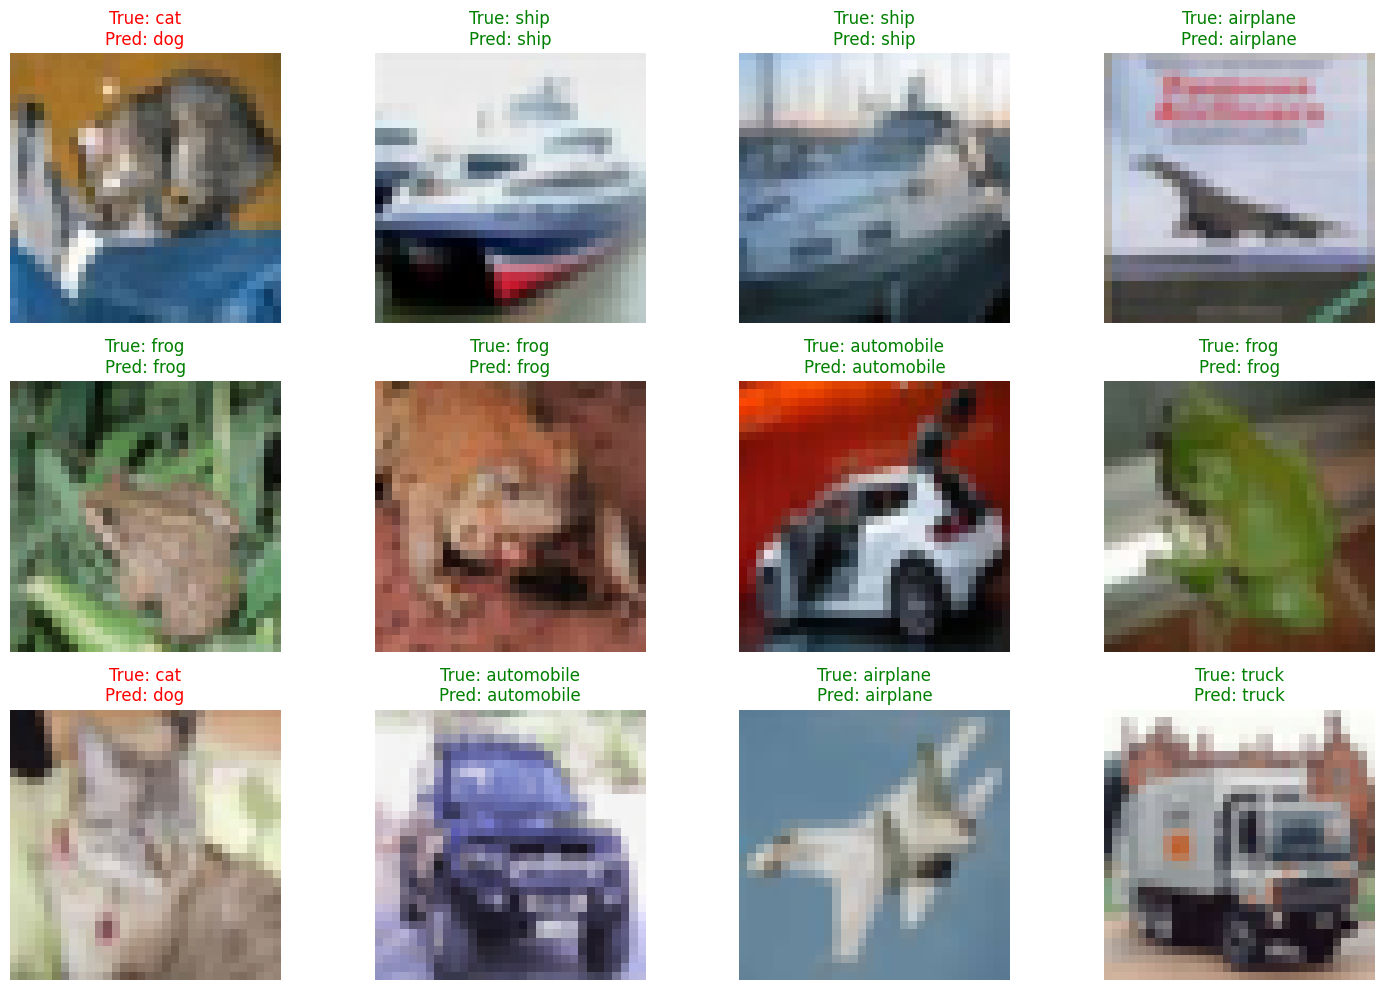

In [17]:
# Sample predictions visualization
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def visualize_predictions(model, test_loader, num_images=12):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images].to(device), labels[:num_images]

    with torch.no_grad():
        outputs = model(images)
        predictions = outputs.argmax(dim=1)

    # Move to CPU for visualization
    images = images.cpu()
    predictions = predictions.cpu()

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)

        # Denormalize image
        img = images[i].clone()
        img = img * torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        plt.imshow(img.permute(1, 2, 0))
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predictions[i]]}',
                 color='green' if labels[i] == predictions[i] else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

## Model Analysis and Architecture Summary

In [20]:
print('=' * 60)
print('VISION TRANSFORMER ARCHITECTURE SUMMARY')
print('=' * 60)

print(f'Image Size: {config.img_size}x{config.img_size}')
print(f'Patch Size: {config.patch_size}x{config.patch_size}')
print(f'Number of Patches: {(config.img_size // config.patch_size) ** 2}')
print(f'Embedding Dimension: {config.embed_dim}')
print(f'Number of Transformer Layers: {config.num_layers}')
print(f'Number of Attention Heads: {config.num_heads}')
print(f'MLP Ratio: {config.mlp_ratio}')
print(f'Dropout Rate: {config.dropout}')
print(f'Total Parameters: {total_params:,}')

print('\n' + '=' * 60)
print('TRAINING CONFIGURATION')
print('=' * 60)

print(f'Batch Size: {config.batch_size}')
print(f'Learning Rate: {config.learning_rate}')
print(f'Weight Decay: {config.weight_decay}')
print(f'Training Epochs: {config.epochs}')
print(f'Warmup Epochs: {config.warmup_epochs}')
print(f'Mixup Alpha: {config.mixup_alpha}')
print(f"Label Smoothing: 0.1")

print('\n' + '=' * 60)
print('FINAL RESULTS')
print('=' * 60)

print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
print(f'Final Test Accuracy: {test_acc:.2f}%')

# Save results
results = {
    'model_config': {
        'img_size': config.img_size,
        'patch_size': config.patch_size,
        'embed_dim': config.embed_dim,
        'num_layers': config.num_layers,
        'num_heads': config.num_heads,
        'mlp_ratio': config.mlp_ratio,
        'total_params': total_params
    },
    'training_config': {
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'weight_decay': config.weight_decay,
        'epochs': config.epochs,
        'warmup_epochs': config.warmup_epochs
    },
    'results': {
        'best_val_accuracy': best_val_acc,
        'final_test_accuracy': test_acc,
        'test_loss': test_loss
    }
}

VISION TRANSFORMER ARCHITECTURE SUMMARY
Image Size: 32x32
Patch Size: 4x4
Number of Patches: 64
Embedding Dimension: 320
Number of Transformer Layers: 8
Number of Attention Heads: 8
MLP Ratio: 4
Dropout Rate: 0.1
Total Parameters: 9,896,650

TRAINING CONFIGURATION
Batch Size: 128
Learning Rate: 0.001
Weight Decay: 0.0005
Training Epochs: 50
Warmup Epochs: 10
Mixup Alpha: 0.8
Label Smoothing: 0.1

FINAL RESULTS
Best Validation Accuracy: 63.80%
Final Test Accuracy: 66.93%
